title: Loan status data analysis with GAM

author: Robert A. Stevens

date: 2024-02-06

## Introduction

### Additive Regression Models

$\eta(X) = \alpha + f_1(x_1) + f_2(x_2) + ... + f_p(x_p)$

Examples:

- Simple Additive: 

$y = f(x) + \epsilon$
    
- Semiparametric: 

$y = X^t\beta + f(z) + \epsilon$
    
- Additive: 

$y = \beta^tX + f_1(z_1) + f_2(z_2) + ... + f_q(z_q) + \epsilon$

- Nonparametric logistic regression: 

$logit(P(X)) = log\left(\frac{P(X)}{1 - P(X)}\right) = \eta(X)$

Source: "Chapter 7: Generalized Additive Models" by Trevor J. Hastie from *Statistical Models in S*, edited by John M. Chambers and Trevor J. Hastie (1992)

### Common Types of Response Variables 

- Continuous
    + Speed of a motorcycle (mph)
    + Fuel efficiency of a car (mpg)
    + Level of pollution in soil (g/kg)

- Binary
    + Presence or absence of an organism in a location
    + Whether a purchase was made
    + Yes/No answer on a survey

### Dataset `loan`

- Binary Response: `loan_status`
    + Indicates whether a loan is currently in default, with 1 being default and 0 being non-default

- Application data:
    + Income: `person_age`
    + Age: `person_income`
    + Home ownership: `person_home_ownership`
    + Employment length: `person_emp_length`
    + Loan intent: `loan_intent`
    + Percent income: `loan_percent_income`

- Behavioral data: 
    + Loan grade: `loan_grade`
    + Loan amount: `loan_amnt`
    + Interest rate: `loan_int_rate`
    + Historical default: `cb_person_default_on_file`
    + Credit history length: `cb_person_cred_hist_length`

# Logistic Regression for Binary Responses

$logit(P(X)) = log\left(\frac{P(X)}{1 - P(X)}\right) = \eta(X)$

At least 3 ways to do logistic regression in Python:

1. `from statsmodels.formula.api import glm`

2. `from scipy.stats import logistic`

3. `from sklearn.linear_model import LogisticRegression`

Each has pros and cons, especially with respect to model fomrulation and available helper functions and methods. Selected # 1 for this tutorial, since it is more similar to PyGAM than # 2 or # 3 - but maybe it's not the "best" choice?

## Import

In [310]:
# import packages

from pygam import f
from pygam import LogisticGAM
from pygam import s
from pygam import te
from statsmodels.formula.api import glm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [311]:
# define accuracy function

def sm_accuracy(y_actual, pred_prob):
    # Purpose: calculate accuracy for statsmodels GLM logistic regression results
    #     Cannot find a function or method for this package like other packages with GLM functionality

    # Define the decision threshold/cutoff
    cutoff = 0.5

    # Compute class predictions: y_prediction
    y_prediction = np.where(pred_prob > cutoff, 1, 0)

    # Compute confusion matrix using crosstab function
    conf_mat = pd.crosstab(y_actual, y_prediction, rownames=["Actual"], colnames=["Predicted"], margins = True)

    # Print the confusion matrix
    print("Confusion Matrix\n")
    print(conf_mat)
    
    # Extract TN, TP, FN and FP from conf_matrix
    TN = conf_mat.loc[0, 0]
    TP = conf_mat.loc[1, 1]
    FN = conf_mat.loc[1, 0]
    FP = conf_mat.loc[0, 1]

    # Calcualate and print accuracy
    accuracy = (TN + TP) / (TN + FN + FP + TP)
    print(f"\naccuracy = {accuracy}")

    return

In [312]:
# import data

loan = pd.read_csv("loan.csv")
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29459 entries, 0 to 29458
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29459 non-null  int64  
 1   person_income               29459 non-null  int64  
 2   person_home_ownership       29459 non-null  object 
 3   person_emp_length           29459 non-null  int64  
 4   loan_intent                 29459 non-null  object 
 5   loan_grade                  29459 non-null  object 
 6   loan_amnt                   29459 non-null  int64  
 7   loan_int_rate               29459 non-null  float64
 8   loan_status                 29459 non-null  int64  
 9   loan_percent_income         29459 non-null  float64
 10  cb_person_default_on_file   29459 non-null  object 
 11  cb_person_cred_hist_length  29459 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 2.7+ MB


In [313]:
# Examine the data frame
loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2,VENTURE,A,2500,7.14,1,0.25,N,2


## Tidy

N/A

## Transform

In [314]:
# required for GAM, but not GLM
X_df = loan.drop('loan_status', axis = 1)
y = loan[['loan_status']]

In [315]:
X_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5,EDUCATION,B,1000,11.14,0.10,N,2
1,25,9600,MORTGAGE,1,MEDICAL,C,5500,12.87,0.57,N,3
2,23,65500,RENT,4,MEDICAL,C,35000,15.23,0.53,N,2
3,24,54400,RENT,8,MEDICAL,C,35000,14.27,0.55,Y,4
4,21,9900,OWN,2,VENTURE,A,2500,7.14,0.25,N,2


In [316]:
X_df["person_home_ownership"] = pd.factorize(X_df["person_home_ownership"])[0].astype(np.uint16)
X_df["loan_intent"] = pd.factorize(X_df["loan_intent"])[0].astype(np.uint16)
X_df["loan_grade"] = pd.factorize(X_df["loan_grade"])[0].astype(np.uint16)
X_df["cb_person_default_on_file"] = pd.factorize(X_df["cb_person_default_on_file"])[0].astype(np.uint16)
X_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,0,5,0,0,1000,11.14,0.10,0,2
1,25,9600,1,1,1,1,5500,12.87,0.57,0,3
2,23,65500,2,4,1,1,35000,15.23,0.53,0,2
3,24,54400,2,8,1,1,35000,14.27,0.55,1,4
4,21,9900,0,2,2,2,2500,7.14,0.25,0,2


In [317]:
X = X_df.to_numpy()

### Summarize data

In [318]:
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,29459.0,27.700058,6.165415,20.00,23.00,26.00,30.00,84.00
person_income,29459.0,65803.732611,51331.095711,4000.00,38500.00,55000.00,79050.00,2039784.00
person_emp_length,29459.0,4.758410,3.980653,0.00,2.00,4.00,7.00,41.00
loan_amnt,29459.0,9583.600937,6314.421006,500.00,5000.00,8000.00,12250.00,35000.00
loan_int_rate,29459.0,11.011529,3.240497,5.42,7.90,10.99,13.47,23.22
loan_status,29459.0,0.219390,0.413840,0.00,0.00,0.00,0.00,1.00
loan_percent_income,29459.0,0.170111,0.106849,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,29459.0,5.788078,4.030672,2.00,3.00,4.00,8.00,30.00


In [319]:
loan.describe(include=["object"]).T

,count,unique,top,freq
person_home_ownership,29459,4,RENT,14890
loan_intent,29459,6,EDUCATION,5852
loan_grade,29459,7,A,9773
cb_person_default_on_file,29459,2,N,24247


In [320]:
loan["person_home_ownership"].value_counts()

person_home_ownership
RENT        14890
MORTGAGE    12119
OWN          2356
OTHER          94
Name: count, dtype: int64

In [321]:
loan["loan_intent"].value_counts()

loan_intent
EDUCATION            5852
MEDICAL              5451
VENTURE              5151
PERSONAL             5012
DEBTCONSOLIDATION    4703
HOMEIMPROVEMENT      3290
Name: count, dtype: int64

In [322]:
loan["loan_grade"].value_counts()

loan_grade
A    9773
B    9393
C    5826
D    3313
E     881
F     214
G      59
Name: count, dtype: int64

In [323]:
loan["cb_person_default_on_file"].value_counts()

cb_person_default_on_file
N    24247
Y     5212
Name: count, dtype: int64

## Visualize

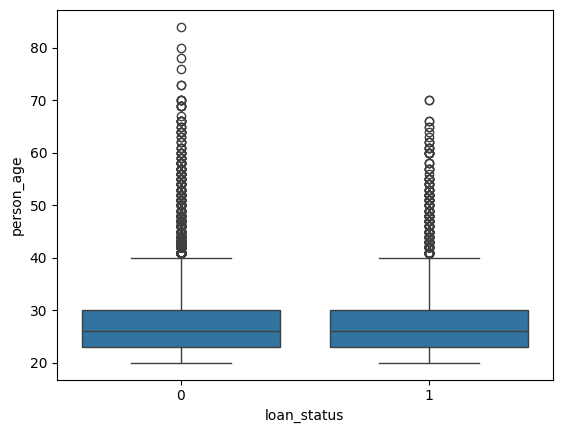

In [324]:
sns.boxplot(data=loan, x="loan_status", y="person_age")
plt.show()

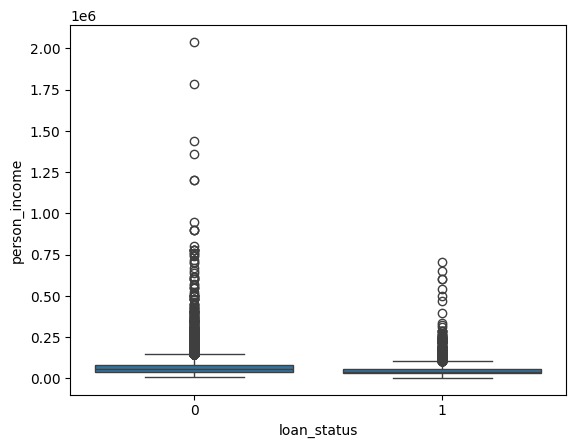

In [325]:
sns.boxplot(data=loan, x="loan_status", y="person_income")
plt.show()

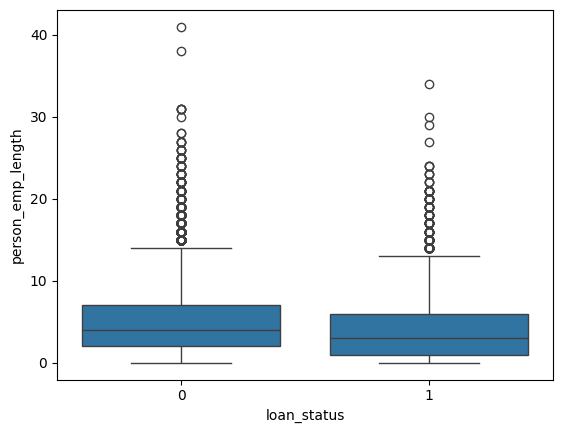

In [326]:
sns.boxplot(data=loan, x="loan_status", y="person_emp_length")
plt.show()

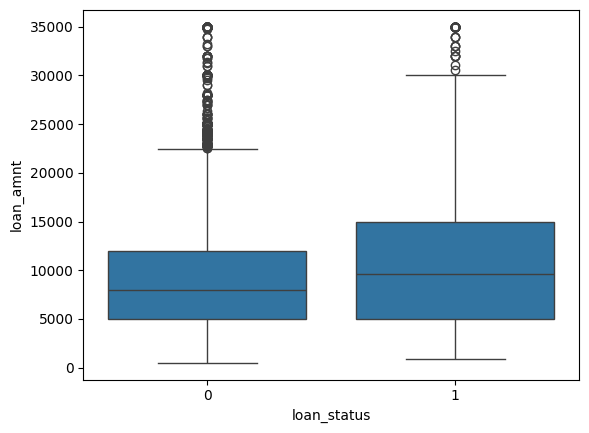

In [327]:
sns.boxplot(data=loan, x="loan_status", y="loan_amnt")
plt.show()

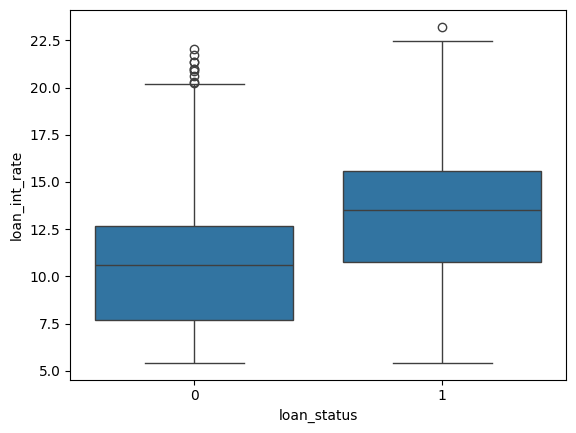

In [328]:
sns.boxplot(data=loan, x="loan_status", y="loan_int_rate")
plt.show()

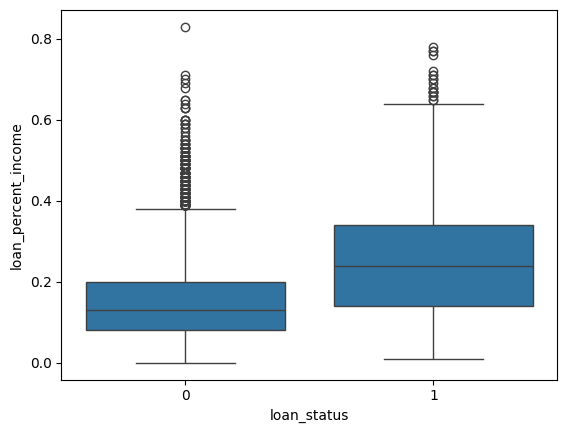

In [329]:
sns.boxplot(data=loan, x="loan_status", y="loan_percent_income")
plt.show()

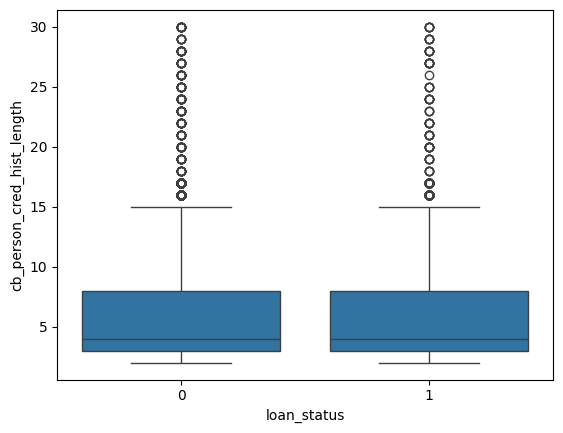

In [330]:
sns.boxplot(data=loan, x="loan_status", y="cb_person_cred_hist_length")
plt.show()

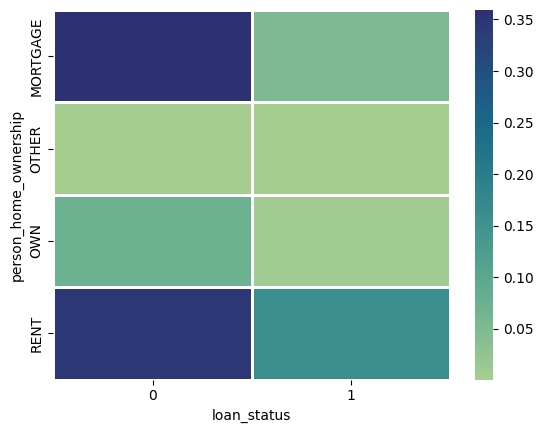

In [331]:
sns.heatmap(pd.crosstab(loan["person_home_ownership"], loan["loan_status"]).div(len(loan)), cmap="crest", linewidths=1)
plt.show()

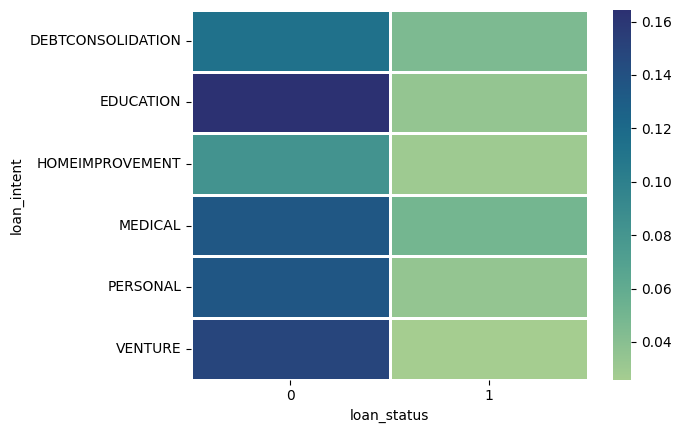

In [332]:
sns.heatmap(pd.crosstab(loan["loan_intent"], loan["loan_status"]).div(len(loan)), cmap="crest", linewidths=1)
plt.show()

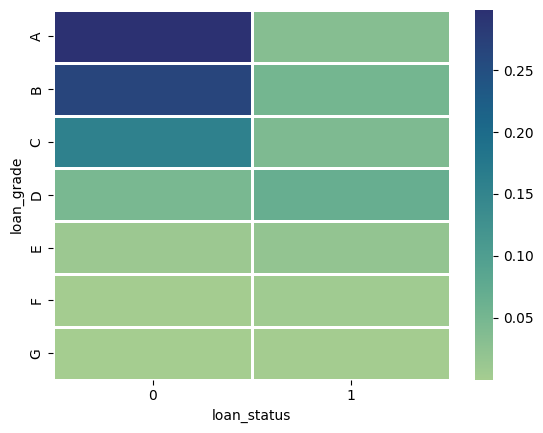

In [333]:
sns.heatmap(pd.crosstab(loan["loan_grade"], loan["loan_status"]).div(len(loan)), cmap="crest", linewidths=1)
plt.show()

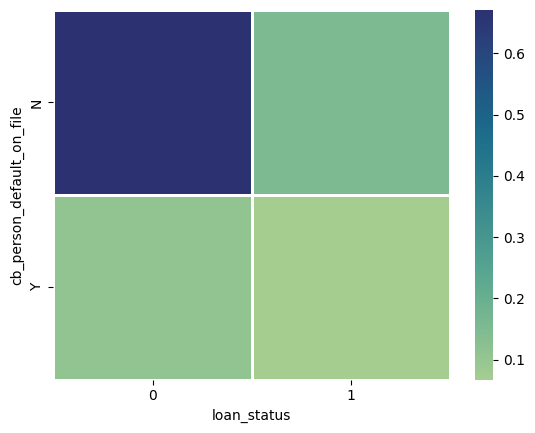

In [334]:
sns.heatmap(pd.crosstab(loan["cb_person_default_on_file"], loan["loan_status"]).div(len(loan)), cmap="crest", linewidths=1)
plt.show()

## Model 

### General Linear Model (GLM) - Logistic

#### GLM Main Effects - Full

In [335]:
formula = """
    loan_status ~ person_age + person_income + person_home_ownership + person_emp_length + loan_intent + loan_grade + loan_amnt + loan_int_rate + loan_percent_income + cb_person_default_on_file + 
        cb_person_cred_hist_length
"""

glm_log_main_full = glm(formula = formula, data = loan, family = sm.families.Binomial()).fit()
glm_log_main_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:                29459
Model:                            GLM   Df Residuals:                    29436
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9973.6
Date:                Tue, 06 Feb 2024   Deviance:                       19947.
Time:                        12:04:56   Pearson chi2:                 3.21e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3128
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -4.1320      0.200    -20.614      0.000      -4.525      -3.739
person_home_ownership[T.OTHER]     0.4097      0.301      1.364      0.173      -0.179       0.999
person_home_ownership[T.OWN]      -1.7449      0.107    -16.384      0.000      -1.954      -1.536
person_home_ownership[T.RENT]      0.8298      0.042     19.692      0.000       0.747       0.912
loan_intent[T.EDUCATION]          -0.8546      0.060    -14.265      0.000      -0.972      -0.737
loan_intent[T.HOMEIMPROVEMENT]     0.0721      0.066      1.086      0.277      -0.058       0.202
loan_intent[T.MEDICAL]            -0.1624      0.057     -2.866      0.004      -0.273      -0.051
loan_intent[T.PERSONAL]           -0.6190      0.061    -10.120      0.000      -0.739      -0.499
loan_intent[T.VENTURE]            -1.1347      0.065    -17.384      0.000      -1.263      -1.007
loan_grade[T.B]                    0.1276      0.081      1.572      0.116      -0.032       0.287
loan_grade[T.C]                    0.2710      0.123      2.209      0.027       0.031       0.511
loan_grade[T.D]                    2.3691      0.154     15.371      0.000       2.067       2.671
loan_grade[T.E]                    2.5577      0.195     13.145      0.000       2.176       2.939
loan_grade[T.F]                    2.8724      0.269     10.683      0.000       2.345       3.399
loan_grade[T.G]                    6.4378      1.054      6.110      0.000       4.373       8.503
cb_person_default_on_file[T.Y]     0.0126      0.052      0.240      0.811      -0.090       0.115
person_age                        -0.0097      0.006     -1.566      0.117      -0.022       0.002
person_income                   1.808e-06    5.5e-07      3.287      0.001     7.3e-07    2.89e-06
person_emp_length                 -0.0141      0.005     -2.796      0.005      -0.024      -0.004
loan_amnt                         -0.0001    4.8e-06    -23.108      0.000      -0.000      -0.000
loan_int_rate                      0.0809      0.018      4.554      0.000       0.046       0.116
loan_percent_income               13.4967      0.277     48.795      0.000      12.955      14.039
cb_person_cred_hist_length         0.0085      0.009      0.909      0.363      -0.010       0.027
==================================================================================================
"""

In [336]:
glm_log_main_full.fittedvalues.values

array([0.00898351, 0.97992749, 0.76285387, ..., 0.45487793, 0.01585639,
       0.1738921 ])

In [337]:
sm_accuracy(loan["loan_status"], glm_log_main_full.fittedvalues.values)

Confusion Matrix

Predicted      0     1    All
Actual                       
0          21908  1088  22996
1           2832  3631   6463
All        24740  4719  29459

accuracy = 0.8669337044706202


#### GLM Main Effects - Reduced

In [338]:
# removed `cb_person_default_on_file`, `person_age`, and `cb_person_cred_hist_length`
glm_log_main_reduced = glm(
    formula = "loan_status ~ person_income + person_home_ownership + person_emp_length + loan_intent + loan_grade + loan_amnt + loan_int_rate + loan_percent_income",
    data = loan,
    family = sm.families.Binomial()
).fit()

glm_log_main_reduced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:                29459
Model:                            GLM   Df Residuals:                    29439
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9975.3
Date:                Tue, 06 Feb 2024   Deviance:                       19951.
Time:                        12:04:57   Pearson chi2:                 3.21e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3127
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -4.3446      0.156    -27.810      0.000      -4.651      -4.038
person_home_ownership[T.OTHER]     0.4110      0.300      1.369      0.171      -0.178       1.000
person_home_ownership[T.OWN]      -1.7434      0.106    -16.376      0.000      -1.952      -1.535
person_home_ownership[T.RENT]      0.8283      0.042     19.666      0.000       0.746       0.911
loan_intent[T.EDUCATION]          -0.8491      0.060    -14.193      0.000      -0.966      -0.732
loan_intent[T.HOMEIMPROVEMENT]     0.0655      0.066      0.988      0.323      -0.064       0.195
loan_intent[T.MEDICAL]            -0.1646      0.057     -2.905      0.004      -0.276      -0.054
loan_intent[T.PERSONAL]           -0.6196      0.061    -10.132      0.000      -0.739      -0.500
loan_intent[T.VENTURE]            -1.1332      0.065    -17.365      0.000      -1.261      -1.005
loan_grade[T.B]                    0.1268      0.081      1.562      0.118      -0.032       0.286
loan_grade[T.C]                    0.2749      0.120      2.295      0.022       0.040       0.510
loan_grade[T.D]                    2.3706      0.152     15.629      0.000       2.073       2.668
loan_grade[T.E]                    2.5582      0.193     13.263      0.000       2.180       2.936
loan_grade[T.F]                    2.8703      0.268     10.712      0.000       2.345       3.396
loan_grade[T.G]                    6.4436      1.053      6.116      0.000       4.379       8.508
person_income                   1.754e-06   5.48e-07      3.198      0.001    6.79e-07    2.83e-06
person_emp_length                 -0.0152      0.005     -3.034      0.002      -0.025      -0.005
loan_amnt                         -0.0001    4.8e-06    -23.143      0.000      -0.000      -0.000
loan_int_rate                      0.0814      0.018      4.579      0.000       0.047       0.116
loan_percent_income               13.5012      0.276     48.830      0.000      12.959      14.043
==================================================================================================
"""

In [339]:
sm_accuracy(loan["loan_status"], glm_log_main_reduced.fittedvalues.values)

Confusion Matrix

Predicted      0     1    All
Actual                       
0          21911  1085  22996
1           2836  3627   6463
All        24747  4712  29459

accuracy = 0.8668997589870667


#### GLM Two-way Interactions - Full => Reduced

In [340]:
# ingored interacctions with two categorical variables:
# person_home_ownership:loan_intent
# person_home_ownership:loan_grade 
# loan_intent:loan_grade

formula = """
    loan_status ~ person_income + person_home_ownership + person_emp_length + loan_intent + loan_grade + loan_amnt + loan_int_rate + loan_percent_income + 
        person_income:person_home_ownership + person_income:person_emp_length + person_income:loan_intent + person_income:loan_grade + person_income:loan_amnt + person_income:loan_int_rate + 
        person_income:loan_percent_income + 
        person_home_ownership:person_emp_length + person_home_ownership:loan_amnt + person_home_ownership:loan_int_rate + person_home_ownership:loan_percent_income + 
        person_emp_length:loan_intent + person_emp_length:loan_grade + person_emp_length:loan_amnt + person_emp_length:loan_int_rate + person_emp_length:loan_percent_income + 
        loan_intent:loan_amnt + loan_intent:loan_int_rate + loan_intent:loan_percent_income + 
        loan_grade:loan_amnt + loan_grade:loan_int_rate + loan_grade:loan_percent_income + 
        loan_amnt:loan_int_rate + loan_amnt:loan_percent_income + 
        loan_int_rate:loan_percent_income
"""

glm_log_inter_full = glm(formula = formula, data = loan, family = sm.families.Binomial()).fit(opt_method="bfgs", maxiter=1000) # default = 100; 1000 fails if did not converge
glm_log_inter_full.summary()

/Users/robertandrewstevens/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/robertandrewstevens/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
/Users/robertandrewstevens/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:                29459
Model:                            GLM   Df Residuals:                    29365
Model Family:                Binomial   Df Model:                           93
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 06 Feb 2024   Deviance:                   4.3316e+05
Time:                        12:07:44   Pearson chi2:                 2.12e+19
No. Iterations:                  1000   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                          -7.091e+14   1.06e+07  -6.66e+07      0.000   -7.09e+14   -7.09e+14
person_home_ownership[T.OTHER]                     -9.902e+13   3.69e+07  -2.69e+06      0.000    -9.9e+13    -9.9e+13
person_home_ownership[T.OWN]                       -1.973e+13    6.9e+06  -2.86e+06      0.000   -1.97e+13   -1.97e+13
person_home_ownership[T.RENT]                      -1.202e+15   3.96e+06  -3.03e+08      0.000    -1.2e+15    -1.2e+15
loan_intent[T.EDUCATION]                            7.945e+14   5.83e+06   1.36e+08      0.000    7.94e+14    7.94e+14
loan_intent[T.HOMEIMPROVEMENT]                      1.373e+15    6.9e+06   1.99e+08      0.000    1.37e+15    1.37e+15
loan_intent[T.MEDICAL]                              1.101e+14   5.95e+06   1.85e+07      0.000     1.1e+14     1.1e+14
loan_intent[T.PERSONAL]                             7.267e+14   5.99e+06   1.21e+08      0.000    7.27e+14    7.27e+14
loan_intent[T.VENTURE]                              2.907e+14   5.92e+06   4.91e+07      0.000    2.91e+14    2.91e+14
loan_grade[T.B]                                     7.255e+14    1.1e+07   6.58e+07      0.000    7.26e+14    7.26e+14
loan_grade[T.C]                                     1.717e+15   1.52e+07   1.13e+08      0.000    1.72e+15    1.72e+15
loan_grade[T.D]                                       5.8e+15   2.02e+07   2.87e+08      0.000     5.8e+15     5.8e+15
loan_grade[T.E]                                     4.029e+15   3.35e+07    1.2e+08      0.000    4.03e+15    4.03e+15
loan_grade[T.F]                                     3.869e+15   7.06e+07   5.48e+07      0.000    3.87e+15    3.87e+15
loan_grade[T.G]                                     -1.44e+16   1.84e+08  -7.81e+07      0.000   -1.44e+16   -1.44e+16
person_income                                      -4.623e+09     93.433  -4.95e+07      0.000   -4.62e+09   -4.62e+09
person_income:person_home_ownership[T.OTHER]       -3.408e+09    134.414  -2.54e+07      0.000   -3.41e+09   -3.41e+09
person_income:person_home_ownership[T.OWN]         -1.534e+09     42.805  -3.58e+07      0.000   -1.53e+09   -1.53e+09
person_income:person_home_ownership[T.RENT]          6.58e+09     27.776   2.37e+08      0.000    6.58e+09    6.58e+09
person_income:loan_intent[T.EDUCATION]             -4.528e+08     38.191  -1.19e+07      0.000   -4.53e+08   -4.53e+08
person_income:loan_intent[T.HOMEIMPROVEMENT]       -6.441e+09     43.702  -1.47e+08      0.000   -6.44e+09   -6.44e+09
person_income:loan_intent[T.MEDICAL]                6.646e+08     38.324   1.73e+07      0.000    6.65e+08    6.65e+08
person_income:loan_intent[T.PERSONAL]               1.496e+09     35.494   4.21e+07      0.000     1.5e+09  

In [341]:
# removed
# person_income:person_home_ownership +  person_income:loan_intent + person_income:loan_grade + 
# person_emp_length:loan_intent + person_emp_length:loan_grade + 
# person_home_ownership:person_emp_length + person_home_ownership:loan_amnt + person_home_ownership:loan_int_rate + person_home_ownership:loan_percent_income + 
# loan_intent:loan_amnt + loan_intent:loan_int_rate + loan_intent:loan_percent_income + 
# loan_grade:loan_amnt + loan_grade:loan_int_rate + loan_grade:loan_percent_income + 

formula = """
    loan_status ~ person_income + person_home_ownership + person_emp_length + loan_intent + loan_grade + loan_amnt + loan_int_rate + loan_percent_income + 
        person_income:person_emp_length + person_income:loan_amnt + person_income:loan_int_rate + person_income:loan_percent_income + 
        person_emp_length:loan_amnt + person_emp_length:loan_int_rate + person_emp_length:loan_percent_income + 
        loan_amnt:loan_int_rate + loan_amnt:loan_percent_income + 
        loan_int_rate:loan_percent_income
"""

glm_log_inter_reduced = glm(formula = formula, data = loan, family = sm.families.Binomial()).fit(opt_method="bfgs", maxiter=1000) # default = 100; 1000 failed too when doesn't converge
glm_log_inter_reduced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:                29459
Model:                            GLM   Df Residuals:                    29429
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9338.9
Date:                Tue, 06 Feb 2024   Deviance:                       18678.
Time:                        12:07:45   Pearson chi2:                 6.04e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3418
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -4.6697      0.333    -14.037      0.000      -5.322      -4.018
person_home_ownership[T.OTHER]            0.4122      0.328      1.257      0.209      -0.230       1.055
person_home_ownership[T.OWN]             -1.8927      0.110    -17.222      0.000      -2.108      -1.677
person_home_ownership[T.RENT]             0.8820      0.044     19.942      0.000       0.795       0.969
loan_intent[T.EDUCATION]                 -0.8709      0.061    -14.263      0.000      -0.991      -0.751
loan_intent[T.HOMEIMPROVEMENT]            0.1467      0.069      2.139      0.032       0.012       0.281
loan_intent[T.MEDICAL]                   -0.4643      0.060     -7.700      0.000      -0.582      -0.346
loan_intent[T.PERSONAL]                  -0.6350      0.062    -10.164      0.000      -0.757      -0.513
loan_intent[T.VENTURE]                   -1.1666      0.067    -17.531      0.000      -1.297      -1.036
loan_grade[T.B]                           0.2764      0.086      3.227      0.001       0.109       0.444
loan_grade[T.C]                           0.4740      0.126      3.774      0.000       0.228       0.720
loan_grade[T.D]                           2.4823      0.158     15.746      0.000       2.173       2.791
loan_grade[T.E]                           2.5870      0.199     12.968      0.000       2.196       2.978
loan_grade[T.F]                           2.6925      0.279      9.648      0.000       2.146       3.240
loan_grade[T.G]                           6.3575      1.058      6.007      0.000       4.283       8.432
person_income                         -1.695e-05   4.16e-06     -4.075      0.000   -2.51e-05    -8.8e-06
person_emp_length                         0.2254      0.023      9.800      0.000       0.180       0.270
loan_amnt                                 0.0012   7.96e-05     14.487      0.000       0.001       0.001
loan_int_rate                             0.2002      0.029      6.940      0.000       0.144       0.257
loan_percent_income                      21.4459      1.391     15.416      0.000      18.719      24.172
person_income:person_emp_length       -1.189e-07   1.37e-07     -0.868      0.385   -3.87e-07    1.49e-07
person_income:loan_amnt                8.898e-10   6.31e-11     14.097      0.000    7.66e-10    1.01e-09
person_income:loan_int_rate            4.904e-07   3.11e-07      1.577      0.115   -1.19e-07     1.1e-06
person_income:loan_percent_income        -0.0015   7.46e-05    -20.504      0.000      -0.002      -0.001
person_emp_length:loan_amnt            4.838e-06   1.23e-06      3.936      0.000    2.43e-06    7.25e-06
person_emp_length:loan_int_rate          -0.0145      0.002     -9.436      0.000      -0.017      -0.011
person_em

In [342]:
# removed
# person_income:person_emp_length
# person_income:loan_int_rate	

formula = """
    loan_status ~ person_income + person_home_ownership + person_emp_length + loan_intent + loan_grade + loan_amnt + loan_int_rate + loan_percent_income + 
        person_income:loan_amnt + person_income:loan_percent_income + 
        person_emp_length:loan_amnt + person_emp_length:loan_int_rate + person_emp_length:loan_percent_income + 
        loan_amnt:loan_int_rate + loan_amnt:loan_percent_income + 
        loan_int_rate:loan_percent_income
"""

glm_log_inter_reduced = glm(formula = formula, data = loan, family = sm.families.Binomial()).fit(opt_method="bfgs", maxiter=1000) # default = 100; 1000 fails when doesn't converge
glm_log_inter_reduced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:                29459
Model:                            GLM   Df Residuals:                    29431
Model Family:                Binomial   Df Model:                           27
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9340.6
Date:                Tue, 06 Feb 2024   Deviance:                       18681.
Time:                        12:07:46   Pearson chi2:                 6.55e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3417
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -4.9793      0.250    -19.936      0.000      -5.469      -4.490
person_home_ownership[T.OTHER]            0.4194      0.327      1.283      0.199      -0.221       1.060
person_home_ownership[T.OWN]             -1.8951      0.110    -17.245      0.000      -2.110      -1.680
person_home_ownership[T.RENT]             0.8828      0.044     19.964      0.000       0.796       0.969
loan_intent[T.EDUCATION]                 -0.8699      0.061    -14.245      0.000      -0.990      -0.750
loan_intent[T.HOMEIMPROVEMENT]            0.1477      0.069      2.155      0.031       0.013       0.282
loan_intent[T.MEDICAL]                   -0.4634      0.060     -7.685      0.000      -0.582      -0.345
loan_intent[T.PERSONAL]                  -0.6352      0.062    -10.165      0.000      -0.758      -0.513
loan_intent[T.VENTURE]                   -1.1667      0.067    -17.525      0.000      -1.297      -1.036
loan_grade[T.B]                           0.2772      0.086      3.236      0.001       0.109       0.445
loan_grade[T.C]                           0.4731      0.126      3.768      0.000       0.227       0.719
loan_grade[T.D]                           2.4800      0.158     15.734      0.000       2.171       2.789
loan_grade[T.E]                           2.5894      0.199     12.980      0.000       2.198       2.980
loan_grade[T.F]                           2.7036      0.279      9.680      0.000       2.156       3.251
loan_grade[T.G]                           6.3523      1.058      6.006      0.000       4.279       8.425
person_income                         -1.118e-05   1.01e-06    -11.116      0.000   -1.31e-05   -9.21e-06
person_emp_length                         0.2150      0.021     10.260      0.000       0.174       0.256
loan_amnt                                 0.0011   7.63e-05     14.722      0.000       0.001       0.001
loan_int_rate                             0.2272      0.023      9.848      0.000       0.182       0.272
loan_percent_income                      22.8574      0.971     23.546      0.000      20.955      24.760
person_income:loan_amnt                8.786e-10   6.04e-11     14.538      0.000     7.6e-10    9.97e-10
person_income:loan_percent_income        -0.0015   7.43e-05    -20.552      0.000      -0.002      -0.001
person_emp_length:loan_amnt            4.097e-06   9.51e-07      4.309      0.000    2.23e-06    5.96e-06
person_emp_length:loan_int_rate          -0.0143      0.002     -9.330      0.000      -0.017      -0.011
person_emp_length:loan_percent_income    -0.5013      0.057     -8.810      0.000      -0.613      -0.390
loan_amnt:loan_int_rate                 7.88e-06   1.27e-06      6.222      0.000     5.4e-06    1.04e-05
loan_amnt

In [343]:
# try to put back in categorical interactions
# person_income:person_home_ownership
# person_income:loan_intent
# person_income:loan_grade
# person_emp_length:loan_intent 
# person_emp_length:loan_grade
# person_home_ownership:person_emp_length
# person_home_ownership:loan_amnt 
# person_home_ownership:loan_int_rate
# person_home_ownership:loan_percent_income
# loan_intent:loan_amnt 
# loan_intent:loan_int_rate 
# loan_intent:loan_percent_income
# loan_grade:loan_amnt

# dropped out:
# loan_amnt:loan_int_rate - after adding person_income:loan_grade
# person_emp_length:loan_int_rate - after adding person_emp_length:loan_grade
# person_home_ownership:loan_int_rate - after adding person_home_ownership:loan_percent_income

# caused to not converge:
# loan_grade:loan_int_rate
# loan_grade:loan_percent_income

formula = """
    loan_status ~ person_income + person_home_ownership + person_emp_length + loan_intent + loan_grade + loan_amnt + loan_int_rate + loan_percent_income + 
        person_income:loan_amnt + person_income:loan_percent_income + 
        person_emp_length:loan_amnt + person_emp_length:loan_percent_income + 
        loan_amnt:loan_percent_income + 
        loan_int_rate:loan_percent_income +
        person_income:person_home_ownership +
        person_income:loan_intent +
        person_income:loan_grade +
        person_emp_length:loan_intent +
        person_emp_length:loan_grade +
        person_home_ownership:person_emp_length +
        person_home_ownership:loan_amnt +
        person_home_ownership:loan_percent_income +
        loan_intent:loan_amnt +
        loan_intent:loan_int_rate +
        loan_intent:loan_percent_income +
        loan_grade:loan_amnt
"""

glm_log_inter_reduced = glm(formula = formula, data = loan, family = sm.families.Binomial()).fit(opt_method="bfgs", maxiter=1000) # default = 100; 1000 fails when doesn't coverge
glm_log_inter_reduced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:                29459
Model:                            GLM   Df Residuals:                    29379
Model Family:                Binomial   Df Model:                           79
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8316.7
Date:                Tue, 06 Feb 2024   Deviance:                       16633.
Time:                        12:07:52   Pearson chi2:                 9.75e+04
No. Iterations:                    47   Pseudo R-squ. (CS):             0.3859
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             -4.1359      0.436     -9.484      0.000      -4.991      -3.281
person_home_ownership[T.OTHER]                        -3.4683      1.541     -2.250      0.024      -6.489      -0.448
person_home_ownership[T.OWN]                          -2.1523      0.379     -5.679      0.000      -2.895      -1.409
person_home_ownership[T.RENT]                         -2.0510      0.173    -11.873      0.000      -2.390      -1.712
loan_intent[T.EDUCATION]                               2.6934      0.379      7.105      0.000       1.950       3.436
loan_intent[T.HOMEIMPROVEMENT]                         5.0858      0.411     12.362      0.000       4.279       5.892
loan_intent[T.MEDICAL]                                 0.4820      0.401      1.202      0.229      -0.304       1.268
loan_intent[T.PERSONAL]                                2.9362      0.371      7.906      0.000       2.208       3.664
loan_intent[T.VENTURE]                                -0.2303      0.455     -0.506      0.613      -1.121       0.661
loan_grade[T.B]                                       -0.2539      0.157     -1.614      0.106      -0.562       0.054
loan_grade[T.C]                                       -0.1683      0.189     -0.890      0.373      -0.539       0.202
loan_grade[T.D]                                        2.2098      0.222      9.943      0.000       1.774       2.645
loan_grade[T.E]                                        2.5416      0.314      8.084      0.000       1.925       3.158
loan_grade[T.F]                                        2.0120      0.541      3.720      0.000       0.952       3.072
loan_grade[T.G]                                     3.902e-06      0.031      0.000      1.000      -0.062       0.062
person_income                                      -3.024e-05    3.9e-06     -7.763      0.000   -3.79e-05   -2.26e-05
person_income:person_home_ownership[T.OTHER]       -7.874e-06   7.52e-06     -1.047      0.295   -2.26e-05    6.86e-06
person_income:person_home_ownership[T.OWN]          3.205e-06   7.37e-06      0.435      0.664   -1.12e-05    1.77e-05
person_income:person_home_ownership[T.RENT]         1.353e-05   2.36e-06      5.723      0.000     8.9e-06    1.82e-05
person_income:loan_intent[T.EDUCATION]             -1.724e-06   3.61e-06     -0.477      0.633    -8.8e-06    5.35e-06
person_income:loan_intent[T.HOMEIMPROVEMENT]       -1.285e-05   4.07e-06     -3.156      0.002   -2.08e-05   -4.87e-06
person_income:loan_intent[T.MEDICAL]                2.868e-06   3.71e-06      0.774      0.439    -4.4e-06    1.01e-05
person_income:loan_intent[T.PERSONAL]               6.988e-06   2.87e-06      2.437      0.015    1.37e-06  

In [344]:
sm_accuracy(loan["loan_status"], glm_log_inter_reduced.fittedvalues.values)

Confusion Matrix

Predicted      0     1    All
Actual                       
0          22204   792  22996
1           2179  4284   6463
All        24383  5076  29459

accuracy = 0.8991479683628093


### Generalized Additive Model (GAM) - Logistic

#### GAM Main Effects - Full

In [345]:
X_df.info()  # reminder for mapping variable # to Column nane and Dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29459 entries, 0 to 29458
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29459 non-null  int64  
 1   person_income               29459 non-null  int64  
 2   person_home_ownership       29459 non-null  uint16 
 3   person_emp_length           29459 non-null  int64  
 4   loan_intent                 29459 non-null  uint16 
 5   loan_grade                  29459 non-null  uint16 
 6   loan_amnt                   29459 non-null  int64  
 7   loan_int_rate               29459 non-null  float64
 8   loan_percent_income         29459 non-null  float64
 9   cb_person_default_on_file   29459 non-null  uint16 
 10  cb_person_cred_hist_length  29459 non-null  int64  
dtypes: float64(2), int64(5), uint16(4)
memory usage: 1.8 MB


In [346]:
gam_log_main_full = LogisticGAM(s(0) + s(1) + f(2) + s(3) + f(4) + f(5) + s(6) + s(7) + s(8) + f(9) + s(10)).gridsearch(X, y)
gam_log_main_full.summary()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:07 ETA:   0:01:10
 18% (2 of 11) |####                     | Elapsed Time: 0:00:10 ETA:   0:00:32
 27% (3 of 11) |######                   | Elapsed Time: 0:00:13 ETA:   0:00:25
 36% (4 of 11) |#########                | Elapsed Time: 0:00:17 ETA:   0:00:28
 45% (5 of 11) |###########              | Elapsed Time: 0:00:21 ETA:   0:00:23
 54% (6 of 11) |#############            | Elapsed Time: 0:00:24 ETA:   0:00:14
 63% (7 of 11) |###############          | Elapsed Time: 0:00:27 ETA:   0:00:12
 72% (8 of 11) |##################       | Elapsed Time: 0:00:31 ETA:   0:00:11
 81% (9 of 11) |####################     | Elapsed Time: 0:00:34 ETA:   0:00:05
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:38 ETA:   0:00:03
100% (11 of 11) |########################| Elapsed Time: 0:00:40 Time:  0:00:40


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    117.4538
Link Function:                        LogitLink Log Likelihood:                                 -9146.7917
Number of Samples:                        29459 AIC:                                            18528.4908
                                                AICc:                                           18529.4554
                                                UBRE:                                               2.6321
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4099
Feature Function                  Lam

/var/folders/0c/wp1qw1z126v3ks75ls3g3zt80000gn/T/ipykernel_12599/2940423116.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_log_main_full.summary()


In [347]:
sm_accuracy(loan["loan_status"], gam_log_main_full.predict(X))

Confusion Matrix

Predicted      0     1    All
Actual                       
0          21911  1085  22996
1           2433  4030   6463
All        24344  5115  29459

accuracy = 0.8805797888590923


In [348]:
gam_log_main_full.accuracy(X, y)

0.8805797888590923

#### GAM Main Effects - Reduced

In [349]:
# remove one-at-a-time
# f(9)
# s(10)
# S(0)
# intercept

gam_log_main_reduced = LogisticGAM(s(1) + f(2) + s(3) + f(4) + f(5) + s(6) + s(7) + s(8),  fit_intercept=False).gridsearch(X, y)
gam_log_main_reduced.summary()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:04 ETA:   0:00:44
 18% (2 of 11) |####                     | Elapsed Time: 0:00:07 ETA:   0:00:25
 27% (3 of 11) |######                   | Elapsed Time: 0:00:10 ETA:   0:00:23
 36% (4 of 11) |#########                | Elapsed Time: 0:00:12 ETA:   0:00:18
 45% (5 of 11) |###########              | Elapsed Time: 0:00:14 ETA:   0:00:12
 54% (6 of 11) |#############            | Elapsed Time: 0:00:17 ETA:   0:00:13
 63% (7 of 11) |###############          | Elapsed Time: 0:00:19 ETA:   0:00:08
 72% (8 of 11) |##################       | Elapsed Time: 0:00:22 ETA:   0:00:08
 81% (9 of 11) |####################     | Elapsed Time: 0:00:23 ETA:   0:00:04
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:25 ETA:   0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:28 Time:  0:00:28


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     85.7361
Link Function:                        LogitLink Log Likelihood:                                 -9164.0982
Number of Samples:                        29459 AIC:                                            18499.6687
                                                AICc:                                           18500.1869
                                                UBRE:                                               2.6303
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4087
Feature Function                  Lam

/var/folders/0c/wp1qw1z126v3ks75ls3g3zt80000gn/T/ipykernel_12599/385669005.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_log_main_reduced.summary()


In [350]:
sm_accuracy(loan["loan_status"], gam_log_main_reduced.predict(X))

Confusion Matrix

Predicted      0     1    All
Actual                       
0          21917  1079  22996
1           2430  4033   6463
All        24347  5112  29459

accuracy = 0.880885298211073


In [351]:
gam_log_main_reduced.accuracy(X, y)

0.880885298211073

#### GAM Two-way Interactions - Full => Reduced

In [352]:
# te(1, 3) would not converge and s(1, 3) gave an error
# s(1, by=4) would not converge
# te(1, 6) and te(1, 8) would not converge
# s(7, by=4) would not converge
# te(6, 7) and te(6, 8) would not converge
# te(7, 8) would not converge
gam_log_inter_reduced = LogisticGAM(
    s(1) + f(2) + s(3) + f(4) + f(5) + s(6) + s(7) + s(8) + 
    s(1, by=2) + s(1, by=5) + te(1, 7) + 
    s(3, by=2) + s(6, by=2) + s(7, by=2) + s(8, by=2) + 
    s(3, by=4) + s(3, by=5) + te(3, 6) + te(3, 7) + te(3, 8) +
    s(6, by=4) + s(8, by=4) +
    s(6, by=5) + s(7, by=5) + s(8, by=5),  
    fit_intercept=False
).gridsearch(X, y)
gam_log_inter_reduced.summary()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:01:08 ETA:   0:11:21
 18% (2 of 11) |####                     | Elapsed Time: 0:01:49 ETA:   0:06:13
 27% (3 of 11) |######                   | Elapsed Time: 0:02:25 ETA:   0:04:49
 36% (4 of 11) |#########                | Elapsed Time: 0:03:06 ETA:   0:04:44
 45% (5 of 11) |###########              | Elapsed Time: 0:03:39 ETA:   0:03:19
 54% (6 of 11) |#############            | Elapsed Time: 0:04:07 ETA:   0:02:16
 63% (7 of 11) |###############          | Elapsed Time: 0:04:34 ETA:   0:01:50
 72% (8 of 11) |##################       | Elapsed Time: 0:05:01 ETA:   0:01:19
 81% (9 of 11) |####################     | Elapsed Time: 0:05:31 ETA:   0:01:01
 90% (10 of 11) |#####################   | Elapsed Time: 0:05:58 ETA:   0:00:26
100% (11 of 11) |########################| Elapsed Time: 0:06:29 Time:  0:06:29


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    275.5425
Link Function:                        LogitLink Log Likelihood:                                 -7947.3193
Number of Samples:                        29459 AIC:                                            16445.7236
                                                AICc:                                           16450.9839
                                                UBRE:                                               2.5657
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4872
Feature Function                  Lam

/var/folders/0c/wp1qw1z126v3ks75ls3g3zt80000gn/T/ipykernel_12599/2188897077.py:16: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_log_inter_reduced.summary()


In [353]:
sm_accuracy(loan["loan_status"], gam_log_inter_reduced.predict(X))

Confusion Matrix

Predicted      0     1    All
Actual                       
0          22322   674  22996
1           2246  4217   6463
All        24568  4891  29459

accuracy = 0.9008791880240334


In [354]:
gam_log_inter_reduced.accuracy(X, y)

0.9008791880240334

## Communicate

```
Model                Log-Likelihood Deviance R-Squared Accuracy
--------------------- -------------- -------- --------- --------
glm_log_main_fill     -9973.6        19947    0.3128    0.8669
glm_log_main_reduced  -9975.3        19951    0.3127    0.8669
glm_log_inter_reduced -8316.7        16633    0.3859    0.8991
```

```
Model                Log-Likelihood AIC      R-Squared Accuracy
--------------------- -------------- -------- --------- --------
gam_log_main_full     -9146.8        18528    0.4099    0.8806
gam_log_main_reduced  -9164.1        18500    0.4087    0.8809
gam_log_inter_reduced -7947.3        16446    0.4872    0.9009
```

**Topics covered:**

- Modeling GLM main effects models and two-way interaction models

- Modeling GAM main effects models and two-way interaction models

**Topics NOT covered:**

- Feature Engineering: Transformations of continuous variables, scaling, normalization, etc.

- Training and testing datasets and checking for overfitting

- Cross Validation (CV) for GLM
    + Used `.gridsearch(X, y)` for GAM, which implements CV

- Hyperparameter tuning/optimization 

- Decision thresholds other than 0.5

- Binary response metrics other than accuracy, e.g. precision, recall, specificity, sensitivity, etc.

- Receiver Operating Curve (ROC) and Area Under Curve (AUC) to compare models

- Dealing with class imbalance for rare events